In [3]:
import os
import pandas as pd
import numpy as np

import scanpy as sc
import pyranges as pr
import warnings

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import SEACells

# Import data generated from ArchR

In [5]:
# TileMatrix data
from scipy.io import mmread
TileMatrix = mmread('./metacell_input/TileMatrix.mtx')

In [6]:
TileMatrix

<6206x9810 sparse matrix of type '<class 'numpy.float64'>'
	with 25475483 stored elements in COOrdinate format>

In [7]:
# Get dimensions
dimensions = TileMatrix.shape
print(dimensions)

(6206, 9810)


In [8]:
# Cell information
cells = pd.read_csv('./metacell_input/cells.csv', index_col=0).iloc[:, 0]

In [9]:
# Bin information
bins = pd.read_csv('./metacell_input/tileMatrix_rowData.csv', index_col=0).iloc[:, :]

In [10]:
bins

,seqnames,idx,start
1,chr1,1,0.0
2,chr1,2,500000.0
3,chr1,3,1000000.0
4,chr1,4,1500000.0
5,chr1,5,2000000.0
...,...,...,...
6202,chrY,115,57000000.0
6203,chrY,116,57500000.0
6204,chrY,117,58000000.0
6205,chrY,118,58500000.0


In [11]:
# Calculate the end index
tileSize = 500000
bins['end'] = bins['start'] + tileSize - 1

# Convert to integer
bins['start'] = bins['start'].astype(int)
bins['end'] = bins['end'].astype(int)

# Create the desired index
bins.index = (
    bins['seqnames'] + '_' +
    bins['idx'].astype(str) + ':' +
    bins['start'].astype(str) + '-' +
    bins['end'].astype(str)
)

# Display the DataFrame
print(bins.head())

                       seqnames  idx    start      end
chr1_1:0-499999            chr1    1        0   499999
chr1_2:500000-999999       chr1    2   500000   999999
chr1_3:1000000-1499999     chr1    3  1000000  1499999
chr1_4:1500000-1999999     chr1    4  1500000  1999999
chr1_5:2000000-2499999     chr1    5  2000000  2499999


In [12]:
ad = sc.AnnData(TileMatrix.T)
ad.obs_names = cells
ad.var_names = bins.index

In [13]:
ad

AnnData object with n_obs × n_vars = 9810 × 6206

In [14]:
ad.X = ad.X.tocsr()

In [15]:
ad

AnnData object with n_obs × n_vars = 9810 × 6206

In [16]:
ad.obsm['X_svd'] = pd.read_csv('./metacell_input/svd.csv', index_col=0).loc[ad.obs_names, : ].values

In [17]:
ad

AnnData object with n_obs × n_vars = 9810 × 6206
    obsm: 'X_svd'

In [18]:
cell_meta = pd.read_csv('./metacell_input/cell_metadata.csv', index_col=0).loc[ad.obs_names, : ]
for col in cell_meta.columns:
    ad.obs[col] = cell_meta[col].values

In [19]:
ad

AnnData object with n_obs × n_vars = 9810 × 6206
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    obsm: 'X_svd'

In [20]:
# Leiden and UMAP
warnings.filterwarnings('ignore')
sc.pp.neighbors(ad, use_rep='X_svd')
sc.tl.umap(ad)
sc.tl.leiden(ad)
warnings.filterwarnings('default')

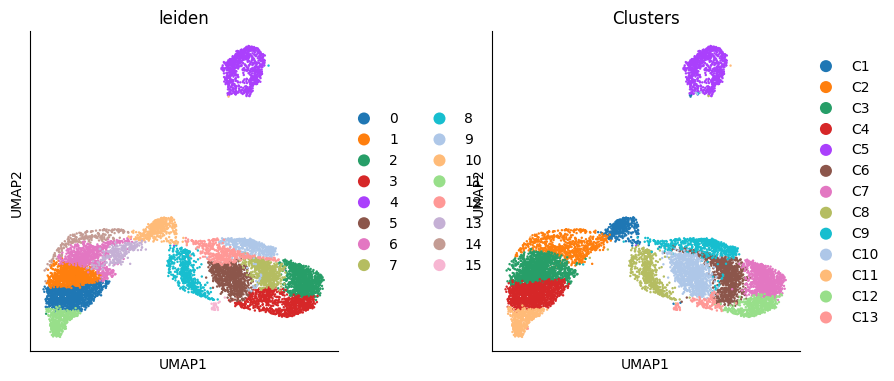

In [21]:
sc.pl.scatter(ad, basis='umap', color=['leiden', 'Clusters'])

# Start Computation Metacell

In [22]:
## User defined parameters

## Core parameters 
n_SEACells = 130
build_kernel_on = 'X_svd' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells

In [23]:
model = SEACells.core.SEACells(ad, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

Welcome to SEACells!


In [24]:
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/9810 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/9810 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/9810 [00:00<?, ?it/s]

Constructing CSR matrix...


In [25]:
# Initialize archetypes
model.initialize_archetypes()

Building kernel on X_svd
Computing diffusion components from X_svd for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 119 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████████████████████████████████████| 21/21 [00:00<00:00, 143.66it/s]

Selecting 11 cells from greedy initialization.


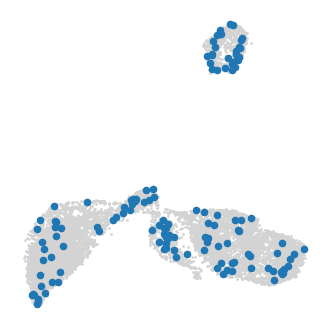

In [26]:
# Plot the initilization to ensure they are spread across phenotypic space
SEACells.plot.plot_initialization(ad, model)

In [27]:
model.fit(min_iter=10, max_iter=50)

Randomly initialized A matrix.
Setting convergence threshold at 0.00181
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 28 iterations.


In [28]:
# You can force the model to run additional iterations step-wise using the .step() function
print(f'Ran for {len(model.RSS_iters)} iterations')
for _ in range(5):
    model.step()
print(f'Ran for {len(model.RSS_iters)} iterations')

Ran for 29 iterations
Ran for 34 iterations


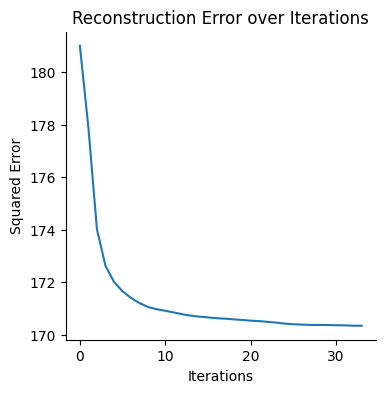

In [29]:
# Check for convergence 
model.plot_convergence()

In [30]:
ad.obs[['SEACell']].head()

,SEACell
index,
scATAC#AAAGGATGTACTTGAC-1,SEACell-124
scATAC#GACCAATAGTCTGTGT-1,SEACell-11
scATAC#CTGAATGGTGATTCCA-1,SEACell-66
scATAC#ACCCAAATCAGGTCTA-1,SEACell-124
scATAC#GGAACTTCACAGTTCA-1,SEACell-124


In [31]:
model.get_hard_assignments().head()

,SEACell
index,
scATAC#AAAGGATGTACTTGAC-1,SEACell-124
scATAC#GACCAATAGTCTGTGT-1,SEACell-11
scATAC#CTGAATGGTGATTCCA-1,SEACell-66
scATAC#ACCCAAATCAGGTCTA-1,SEACell-124
scATAC#GGAACTTCACAGTTCA-1,SEACell-124


In [32]:
SEACell_ad = SEACells.core.summarize_by_SEACell(ad, SEACells_label='SEACell', summarize_layer='X')
SEACell_ad

100%|████████████████████████████████████████| 130/130 [00:00<00:00, 386.58it/s]
/home/hzz/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 130 × 6206
    layers: 'raw'

In [33]:
SEACell_ad.X

<130x6206 sparse matrix of type '<class 'numpy.float64'>'
	with 596714 stored elements in Compressed Sparse Row format>

In [34]:
import pandas as pd

# Convert to dense format (if small enough)
dense_matrix = SEACell_ad.X.todense()

# Convert to DataFrame for better visualization
df = pd.DataFrame(dense_matrix)

# Display the first few rows
df.head()

,0,1,2,3,4,5,6,7,8,9,...,6196,6197,6198,6199,6200,6201,6202,6203,6204,6205
0,0.0,0.0,30.0,29.0,0.0,0.0,25.0,26.0,0.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,11.0,11.0,0.0,0.0,11.0,7.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,29.0,27.0,0.0,0.0,25.0,26.0,0.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,36.0,32.0,0.0,0.0,36.0,36.0,0.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,34.0,36.0,0.0,0.0,23.0,33.0,0.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Metacell Visualization

/usr/local/lib/python3.10/dist-packages/SEACells-0.3.3-py3.10.egg/SEACells/plot.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mcs = umap.groupby("SEACell").mean().reset_index()
/usr/local/lib/python3.10/dist-packages/seaborn-0.13.2-py3.10.egg/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/usr/local/lib/python3.10/dist-packages/seaborn-0.13.2-py3.10.egg/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


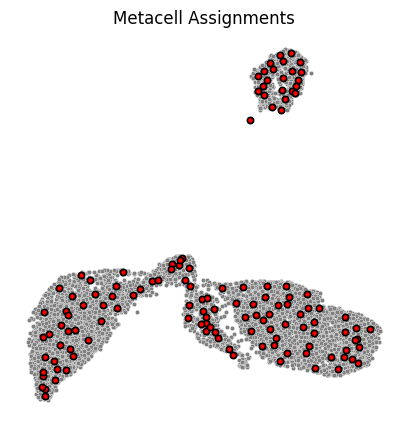

In [35]:
SEACells.plot.plot_2D(ad, key='X_umap', colour_metacells=False)

/usr/local/lib/python3.10/dist-packages/SEACells-0.3.3-py3.10.egg/SEACells/plot.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mcs = umap.groupby("SEACell").mean().reset_index()
/usr/local/lib/python3.10/dist-packages/seaborn-0.13.2-py3.10.egg/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/usr/local/lib/python3.10/dist-packages/seaborn-0.13.2-py3.10.egg/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


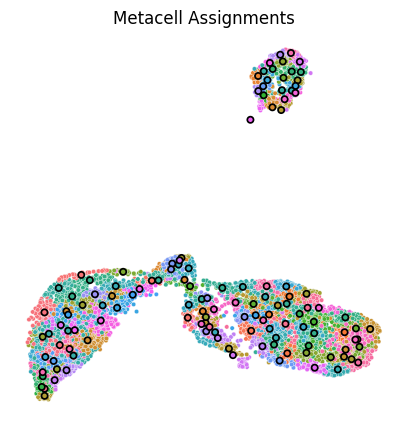

In [36]:
SEACells.plot.plot_2D(ad, key='X_umap', colour_metacells=True)

,0,1,2,3,4,5,6,7,8,9,...,6196,6197,6198,6199,6200,6201,6202,6203,6204,6205
0,0.0,0.0,30.0,29.0,0.0,0.0,25.0,26.0,0.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,11.0,11.0,0.0,0.0,11.0,7.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,29.0,27.0,0.0,0.0,25.0,26.0,0.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,36.0,32.0,0.0,0.0,36.0,36.0,0.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,34.0,36.0,0.0,0.0,23.0,33.0,0.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,0.0,0.0,100.0,96.0,0.0,0.0,38.0,88.0,0.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126,0.0,0.0,36.0,37.0,0.0,0.0,18.0,34.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
127,0.0,0.0,77.0,72.0,0.0,0.0,28.0,65.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128,0.0,0.0,36.0,35.0,0.0,0.0,11.0,30.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# Save the DataFrame to a CSV file
df.to_csv('./metacell_output/seacell_data.csv', index=False)  # index=False excludes the index column

# scENCORE part
This notebook contains data analysis using scENCORE methods


## Normalization and correlation

In [1]:
import os
import pandas as pd
import numpy as np

import scanpy as sc
import pyranges as pr
import warnings

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read the Metacell x Bin matrix CSV file into a DataFrame
df = pd.read_csv('./metacell_output/seacell_data.csv')

# Display Metacell x Bin matrix
df

,0,1,2,3,4,5,6,7,8,9,...,6196,6197,6198,6199,6200,6201,6202,6203,6204,6205
0,0.0,0.0,30.0,29.0,0.0,0.0,25.0,26.0,0.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,11.0,11.0,0.0,0.0,11.0,7.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,29.0,27.0,0.0,0.0,25.0,26.0,0.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,36.0,32.0,0.0,0.0,36.0,36.0,0.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,34.0,36.0,0.0,0.0,23.0,33.0,0.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,0.0,0.0,100.0,96.0,0.0,0.0,38.0,88.0,0.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126,0.0,0.0,36.0,37.0,0.0,0.0,18.0,34.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
127,0.0,0.0,77.0,72.0,0.0,0.0,28.0,65.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128,0.0,0.0,36.0,35.0,0.0,0.0,11.0,30.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Normalization
row_sum = df.sum(axis=1)
normalized_df = df.div(row_sum, axis=0)

# Compute the correlation matrix
corr_matrix = normalized_df.corr()

# Set negative correlations to zero (if required)
corr_matrix[corr_matrix < 0] = 0


In [4]:
corr_matrix

,0,1,2,3,4,5,6,7,8,9,...,6196,6197,6198,6199,6200,6201,6202,6203,6204,6205
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,1.00000,0.99088,NaN,NaN,0.0,0.942849,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.99088,1.00000,NaN,NaN,0.0,0.949023,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Replace NaN values with 0
corr_matrix_filled = corr_matrix.fillna(0)

# Check the output
print(corr_matrix_filled)

        0    1        2        3    4    5    6         7    8    9  ...  \
0     0.0  0.0  0.00000  0.00000  0.0  0.0  0.0  0.000000  0.0  0.0  ...   
1     0.0  0.0  0.00000  0.00000  0.0  0.0  0.0  0.000000  0.0  0.0  ...   
2     0.0  0.0  1.00000  0.99088  0.0  0.0  0.0  0.942849  0.0  0.0  ...   
3     0.0  0.0  0.99088  1.00000  0.0  0.0  0.0  0.949023  0.0  0.0  ...   
4     0.0  0.0  0.00000  0.00000  0.0  0.0  0.0  0.000000  0.0  0.0  ...   
...   ...  ...      ...      ...  ...  ...  ...       ...  ...  ...  ...   
6201  0.0  0.0  0.00000  0.00000  0.0  0.0  0.0  0.000000  0.0  0.0  ...   
6202  0.0  0.0  0.00000  0.00000  0.0  0.0  0.0  0.000000  0.0  0.0  ...   
6203  0.0  0.0  0.00000  0.00000  0.0  0.0  0.0  0.000000  0.0  0.0  ...   
6204  0.0  0.0  0.00000  0.00000  0.0  0.0  0.0  0.000000  0.0  0.0  ...   
6205  0.0  0.0  0.00000  0.00000  0.0  0.0  0.0  0.000000  0.0  0.0  ...   

      6196  6197  6198  6199  6200  6201  6202  6203  6204  6205  
0      0.0   0.0   0

In [6]:
# Save correlation matrix
# Save the DataFrame to a CSV file
corr_matrix_filled.to_csv('./correlation/corr_matrix_filled.csv', index=False)

In [7]:
# Read the Metacell x Bin matrix CSV file into a DataFrame
corr_matrix_filled = pd.read_csv('./correlation/corr_matrix_filled.csv')

# Display Metacell x Bin matrix
corr_matrix_filled

,0,1,2,3,4,5,6,7,8,9,...,6196,6197,6198,6199,6200,6201,6202,6203,6204,6205
0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.00000,0.99088,0.0,0.0,0.0,0.942849,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.99088,1.00000,0.0,0.0,0.0,0.949023,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6201,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6202,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6203,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6204,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


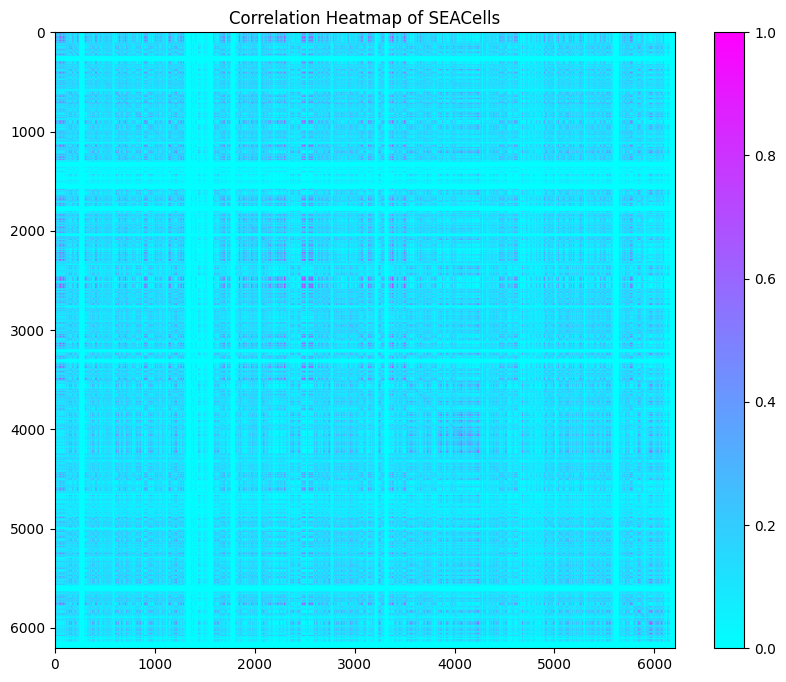

In [8]:
# Plot the correlation matrix
plt.figure(figsize=(10, 8))  # Adjust size as needed
plt.imshow(corr_matrix_filled, cmap=plt.cm.cool, aspect='auto')
plt.colorbar()
plt.title('Correlation Heatmap of SEACells')
plt.show()

## Generate weighted edgelist

In [9]:
import networkx as nx
import numpy as np

# Ensure the correlation matrix is in the right format
print("corr shape: ", corr_matrix_filled.shape)

# Convert the DataFrame to a NumPy array
A = np.array(corr_matrix_filled)

# Create a graph from the NumPy array
G = nx.from_numpy_array(A)

# Optionally, visualize or work with the graph
print("Graph information:")
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Edges:", G.edges())
print("Nodes:", G.nodes())

corr shape:  (6206, 6206)
Graph information:
Number of nodes: 6206
Number of edges: 5293071
Edges: 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [10]:
nx.write_weighted_edgelist(G, "./embedding/weighted.edgelist")

## Generate bcsr file

In [11]:
# https://github.com/aicb-ZhangLabs/scENCORE/blob/main/tool/generate_bcsr.py
# # The above code was downloaded to local folder.
# Run the script with arguments directly
!python3 generate_bcsr.py --format weighted_edgelist --undirected --sep " " ./embedding/weighted.edgelist ./tmp/tmp.bcsr

2024-07-20 14:51:40,153 INFO convert graph from ./embedding/weighted.edgelist to ./tmp/tmp.bcsr
2024-07-20 14:51:42,590 INFO Node IDs are numbers: True
2024-07-20 14:51:52,357 INFO num vertices=4633; num edges=10581509;
2024-07-20 14:51:53,346 INFO done.


## Graph Embedding

In [12]:
! ./verse \
    -input ./tmp/tmp.bcsr \
    -output ./tmp/tmp.bin \
    -dim 32 \
    -alpha 0.10 \
    -threads 4 \
    -nsamples 3

nv: 4633, ne: 10581509
Total steps (mil): 463.3

Calculations took 0.00917485 s to run


## Save Graph Embedding

In [14]:
# https://github.com/aicb-ZhangLabs/scENCORE/blob/main/tool/generate_embeddings.py
# The above code was downloaded to local folder and modified.
!python3 ./generate_embeddings.py -d ./embedding/ -g corr -es 32 -alpha 0.10 -nsamples 3


Loading embeddings...
Done loading embeddings (shape: (4633, 32)).


## Unsupervised clustering

Text(0.5, 1.0, 'UMAP Plot with Separation')

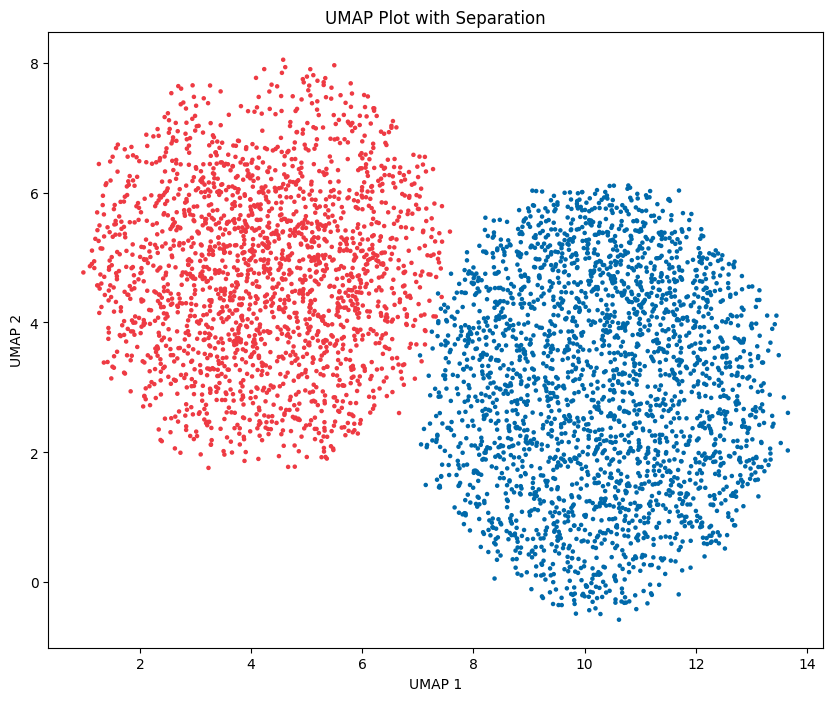

In [12]:
# This part is just to avoid the warning above.

import anndata as ad
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

# Load embedding
embedding_size = 128
meta_number = 130
embedding = np.load("./embedding/corr_0_1_VERSE_32_alpha01_ns3.npy")
adata = ad.AnnData(embedding)

# Process with scanpy
sc.pp.neighbors(adata, n_neighbors=50, use_rep='X')
sc.tl.leiden(adata, resolution=0.67)
sc.tl.umap(adata)


# Get UMAP coordinates and labels
pos = np.array(adata.obsm['X_umap'])
labels = adata.obs['leiden']

# Define offsets for separation
offset_dict = {
    '0': (3, -1.0),  # Move cluster 0 to the right
    '1': (-3, 1.0)  # Move other clusters to the left
}

# Apply offsets
adjusted_pos = pos.copy()
for label, offset in offset_dict.items():
    mask = (labels == label)
    adjusted_pos[mask] += offset

# Create color list
color_list = []
for label in labels:
    if label == '0':
        color_list.append('#0069aa')  # Blue
    else:
        color_list.append('#ee3a43')  # Red

# Plot adjusted UMAP
plt.figure(figsize=(10, 8))
plt.scatter(adjusted_pos[:, 0], adjusted_pos[:, 1], c=color_list, s=5, marker='o')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Plot with Separation')

In [44]:
adata.X

array([[-0.37909803,  0.40902343, -0.01166611, ..., -0.11140066,
        -0.01988618, -0.40582594],
       [-0.18419108, -0.09137812, -0.32210663, ..., -0.40875384,
        -0.17941988,  0.10066287],
       [-0.41944823,  0.33501986, -0.5332182 , ...,  0.18603905,
        -0.14620249, -0.21366209],
       ...,
       [-0.42125896, -0.27146494, -0.32350487, ...,  0.5284689 ,
         0.25769916, -0.2113611 ],
       [-0.445002  ,  0.21633412,  0.42642695, ..., -0.45783326,
         0.39269048,  0.5376928 ],
       [-0.3248089 , -0.4933955 ,  0.3804332 , ..., -0.18509303,
        -0.02546112, -0.32866833]], dtype=float32)

In [45]:
print("adata dimensions:", adata.shape)

adata dimensions: (4633, 32)


In [46]:
adata.obs

,leiden
0,0
1,9
2,1
3,4
4,1
...,...
4628,1
4629,1
4630,2
4631,0
